In [1]:
import string
import copy
import time
%matplotlib inline
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
!pip install --quiet googletrans==3.1.0a0
from googletrans import Translator
from transformers import RobertaModel, AdamW, RobertaTokenizer, RobertaConfig
from torch.optim import SGD
import random
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
import gc
import math
gc.enable()

SEED = 42
BATCH_SIZE = 16
MAX_LENGTH = 256
ROBERTA_FP = '../input/roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONASSEED'] = str(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 4.9.2 requires ruamel_yaml>=0.11.14, which is not installed.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 3.1.0 which is incompatible.
gcsfs 2021.6.0 requires fsspec==2021.06.0, but you have fsspec 2021.6.1 which is incompatible.
earthengine-api 0.1.272 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
aiobotocore 1.3.1 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.20.105 which is incompatible.


In [2]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [3]:
class RobertaForSequenceRegression(nn.Module):
    def __init__(self):
        super(RobertaForSequenceRegression, self).__init__()
        self.config = RobertaConfig.from_pretrained(ROBERTA_FP)
        self.config.update({"output_hidden_states":True, 
                       "layer_norm_eps": 1e-7})  
        self.roberta = RobertaModel.from_pretrained(ROBERTA_FP, config = self.config)
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
#         self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.linear = nn.Linear(768, 1)
        
        self._init_weights(self.layer_norm)
        self._init_weights(self.linear)
 
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean = 0.0, std = self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)     

    def forward(self, input_ids, attention_mask):
        pooled_output = self.roberta(input_ids, attention_mask)
        last_layer_hidden_states = pooled_output.hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)
        pooled_output = self.layer_norm(context_vector)
#         pooled_output = self.dropout(pooled_output)
        outputs = self.linear(pooled_output)
        return outputs.view(-1)

In [4]:
def RMSELoss(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs, targets))

In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

class regressor_stratified_cv:
    def __init__(self, n_splits = 10, n_repeats = 2, group_count = 10,
                 random_state = 0, strategy = 'quantile'):
        self.group_count = group_count
        self.strategy = strategy
        self.cvkwargs = dict(n_splits = n_splits, n_repeats = n_repeats, 
                             random_state = random_state)
        self.cv = RepeatedStratifiedKFold(**self.cvkwargs)
        self.discretizer = KBinsDiscretizer(n_bins = self.group_count, encode = 'ordinal',
                                            strategy = self.strategy)  
            
    def split(self, X, y, groups = None):
        kgroups=self.discretizer.fit_transform(y[:, None])[:, 0]
        return self.cv.split(X, kgroups, groups)
    
    def get_n_splits(self, X, y, groups = None):
        return self.cv.get_n_splits(X, y, groups)

In [6]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:197]    
    attention_parameters = named_parameters[199:203]
    regressor_parameters = named_parameters[203:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 1e-5

        if layer_num >= 69:        
            lr = 2e-5

        if layer_num >= 133:
            lr = 7e-5

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters)

In [7]:
df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [8]:
df["text"] = df['excerpt'].apply(lambda x: x.replace('\n',''))

In [9]:
class TokenDataset(Dataset):
    def __init__(self, tokenizer, text, target = None, is_test=False):
        self.text = text.tolist()
        self.target = target
        self.is_test = is_test
        self.max_len = MAX_LENGTH
        self.tokenizer = tokenizer
         
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        inputs = self.tokenizer.encode_plus(
            self.text[idx],
            padding = 'max_length',            
            max_length = self.max_len,
            truncation = True,
            return_attention_mask=True
        ) 
        input_ids = torch.tensor(inputs['input_ids'])
        attention_mask = torch.tensor(inputs['attention_mask'])
        targets = torch.tensor(self.target[idx], dtype=torch.float)
        if self.is_test:
            return (input_ids, attention_mask)  
        else:    
            return (input_ids, attention_mask, targets)  

In [10]:
def change_trans_target(target, se):
    return target + random.uniform(0, se)

In [11]:
def change_syn_target(target, se):
    return target - random.uniform(0, se)

In [12]:
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [13]:
def synonym_replacement(words, n):
    
    words = words.split()
    
    stop_words = []
    for w in stopwords.words('english'):
        stop_words.append(w)
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
#             print("replaced", random_word, "with", synonym)
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return sentence

In [14]:
def translation(df):
    df_trans = df.copy(deep=True)
    translator = Translator()
    df_trans['text_es'] = df_trans['text'].apply(translator.translate, src='en', dest='es').apply(getattr, args=('text',))
    df_trans['text'] = df_trans['text_es'].apply(translator.translate, src='es', dest='en').apply(getattr, args=('text',))
    df_trans['target']  = df_trans.apply(lambda f: change_trans_target(f['target'],f['standard_error']), axis=1)
    df_trans.drop(columns=['text_es'], inplace = True)
    return df_trans

In [15]:
def get_syn(df):
    df_syn = df.copy(deep=True)
    df_syn["text"] = df_syn["text"].apply(lambda x: synonym_replacement(x, 4))
    df_syn['target']  = df_syn.apply(lambda f: change_syn_target(f['target'],f['standard_error']), axis=1)
    return df_syn

In [16]:
n_splits = 5
n_repeats = 1
group_count = 12

cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
                           group_count = group_count, random_state = 42, strategy = 'quantile')

epochs = 15
n_epochs_stop = 5
epochs_no_improve = 0
training_stats = []
i = 1
eval_losses = []

for train_idx, test_idx in cv.split(df["text"], df["target"].values):
    gc.collect()
    print('======== Fold {:}  ========'.format(i))
    train_data = df.loc[train_idx]
    test_data = df.loc[test_idx]
    df_trans = translation(train_data)
    df_syn = get_syn(train_data)
    train_data = pd.concat([train_data, df_trans, df_syn], ignore_index=True, sort=False)
    del df_trans, df_syn
    
    tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_FP)
    
    train_set = TokenDataset(tokenizer,
                            text = train_data['text'].values,
                            target = train_data['target'].values
                           )
    
    test_set = TokenDataset(tokenizer,
                           text = test_data['text'].values,
                           target = test_data['target'].values
                          )
    
    del train_data

    train_dataloader = DataLoader(train_set, 
                                  batch_size = BATCH_SIZE, 
                                  shuffle = True, 
                                  num_workers=4,
                                  pin_memory=True, 
                                  drop_last=False)

    test_dataloader = DataLoader(test_set, 
                                 batch_size = BATCH_SIZE, 
                                 shuffle = False, 
                                 num_workers=4,
                                 pin_memory=True,
                                 drop_last=False)
    
    del train_set, test_set
    gc.collect()
    
    model = RobertaForSequenceRegression().to(device) 
    optimizer = create_optimizer(model)
    total_steps = (len(train_dataloader) * epochs) 
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, 
                                                num_training_steps= total_steps)  
    
    iter_eval_loss = []
    min_eval_loss = np.Inf
    best_loss = np.Inf
    writer = SummaryWriter(log_dir=f'fold_{i}')
    
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        t0_train = time.time()
        
        # training
        model.train()
        tr_loss = []
        for step, (input_ids, attention_mask, target) in enumerate(train_dataloader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)            
            target = target.to(device)  
            optimizer.zero_grad()
            output = model(input_ids, attention_mask)
            loss = RMSELoss(output, target)
            loss.backward()
            optimizer.step()
            tr_loss.append(loss.detach().cpu().numpy().tolist())
            scheduler.step()
        
            if (step % 20 == 0) or (step == (len(train_dataloader)-1)):
                # evaluation
                t1_train = time.time()
                t0_eval = time.time()
                all_targets, all_preds = [], []
                model.eval()   
                eval_loss = []
                valid_loss = 0
                # disable gradients 
                with torch.no_grad():
                    for step, (input_ids, attention_mask, target) in enumerate(test_dataloader):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)   
                        target = target.to(device)
                        output = model(input_ids, attention_mask)
                        loss = RMSELoss(output, target)
                        eval_loss.append(loss.cpu().detach().numpy().tolist())
                        
                    valid_loss = np.array(eval_loss).mean()
                    if valid_loss <= best_loss:
                        print(f"epoch:{epoch_i} | Train Loss:{np.array(tr_loss).mean()} | Validation loss:{valid_loss}")
                        print(f"Validation loss Decreased from {best_loss} to {valid_loss}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(), f'model_fold_{i}.bin')
        
        torch.cuda.empty_cache()
        train_losses = np.mean(tr_loss)  
        training_time = format_time(t1_train - t0_train)
        writer.add_scalar("train_loss", train_losses, epoch_i)
        print("Train loss: ", train_losses)
        print("Training epcoh took: {:}".format(training_time))
        
        del loss
        del output
        del input_ids
        del target
        del attention_mask
            
        gc.collect()
        
        epoch_eval_loss = np.mean(eval_loss)
        eval_time = format_time(time.time() - t0_eval)
        writer.add_scalar("eval_loss", epoch_eval_loss, epoch_i)
        print("Eval loss: ", epoch_eval_loss)
        print("Evaluation took: {:}".format(eval_time))
        
        # recording all statistics from this epoch
        training_stats.append({
            'fold' : i,
            'epoch': epoch_i + 1,
            'Training Loss': train_losses,
            'Eval Loss': epoch_eval_loss,
            'Training Time': training_time,
            'Eval Time': eval_time
        })
        
        # early stopping and saving best model
        if epoch_eval_loss < min_eval_loss:
            epochs_no_improve = 0
            min_eval_loss = epoch_eval_loss
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= n_epochs_stop and epoch_i + 1 >= 10:
            print('Early stopping! Epoch {:}'.format(epoch_i + 1) )
            break
        else:
            continue
     
    i += 1    
    torch.cuda.empty_cache()
    del model
    gc.collect()
writer.flush()
writer.close()

======== Fold 1  ========


Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 15 ========
epoch:0 | Train Loss:1.6429141759872437 | Validation loss:1.127589796980222
Validation loss Decreased from inf to 1.127589796980222
epoch:0 | Train Loss:0.9705165709768023 | Validation loss:0.6410874732666545
Validation loss Decreased from 1.127589796980222 to 0.6410874732666545
epoch:0 | Train Loss:0.8006277949344821 | Validation loss:0.578940731783708
Validation loss Decreased from 0.6410874732666545 to 0.578940731783708
epoch:0 | Train Loss:0.7470451085293879 | Validation loss:0.5642159407337507
Validation loss Decreased from 0.578940731783708 to 0.5642159407337507
epoch:0 | Train Loss:0.6763409307180357 | Validation loss:0.5357072974244753
Validation loss Decreased from 0.5642159407337507 to 0.5357072974244753
epoch:0 | Train Loss:0.6333764323872098 | Validation loss:0.5126698936025301
Validation loss Decreased from 0.5357072974244753 to 0.5126698936025301
epoch:0 | Train Loss:0.6178693071479711 | Validation loss:0.4999048544300927
Validation loss De

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 15 ========
epoch:0 | Train Loss:1.4276278018951416 | Validation loss:1.0374847675363223
Validation loss Decreased from inf to 1.0374847675363223
epoch:0 | Train Loss:0.9268928255353656 | Validation loss:0.7167982227272458
Validation loss Decreased from 1.0374847675363223 to 0.7167982227272458
epoch:0 | Train Loss:0.7920071359087781 | Validation loss:0.5812954960597886
Validation loss Decreased from 0.7167982227272458 to 0.5812954960597886
epoch:0 | Train Loss:0.695742507087122 | Validation loss:0.5223665063579878
Validation loss Decreased from 0.5812954960597886 to 0.5223665063579878
epoch:0 | Train Loss:0.6627321708286907 | Validation loss:0.5198043609658877
Validation loss Decreased from 0.5223665063579878 to 0.5198043609658877
epoch:0 | Train Loss:0.6130030459388163 | Validation loss:0.5032599742213885
Validation loss Decreased from 0.5198043609658877 to 0.5032599742213885
epoch:0 | Train Loss:0.5980346242454757 | Validation loss:0.48265911638736725
Validation l

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 15 ========
epoch:0 | Train Loss:1.043393850326538 | Validation loss:1.2013987534575992
Validation loss Decreased from inf to 1.2013987534575992
epoch:0 | Train Loss:0.9017360934189388 | Validation loss:0.8531091428465314
Validation loss Decreased from 1.2013987534575992 to 0.8531091428465314
epoch:0 | Train Loss:0.8561629747472158 | Validation loss:0.7192743966976801
Validation loss Decreased from 0.8531091428465314 to 0.7192743966976801
epoch:0 | Train Loss:0.7908092776282889 | Validation loss:0.6618291578359075
Validation loss Decreased from 0.7192743966976801 to 0.6618291578359075
epoch:0 | Train Loss:0.7392952854250684 | Validation loss:0.5950257463587655
Validation loss Decreased from 0.6618291578359075 to 0.5950257463587655
epoch:0 | Train Loss:0.6972285798280546 | Validation loss:0.5635017760925822
Validation loss Decreased from 0.5950257463587655 to 0.5635017760925822
epoch:0 | Train Loss:0.666865901267233 | Validation loss:0.5433081628547775
Validation los

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 15 ========
epoch:0 | Train Loss:1.1011886596679688 | Validation loss:1.0518624418311648
Validation loss Decreased from inf to 1.0518624418311648
epoch:0 | Train Loss:0.9308604825110662 | Validation loss:0.7363587303294076
Validation loss Decreased from 1.0518624418311648 to 0.7363587303294076
epoch:0 | Train Loss:0.8881436986167256 | Validation loss:0.6737906792097621
Validation loss Decreased from 0.7363587303294076 to 0.6737906792097621
epoch:0 | Train Loss:0.7918473912067101 | Validation loss:0.588196664220757
Validation loss Decreased from 0.6737906792097621 to 0.588196664220757
epoch:0 | Train Loss:0.7290216923350155 | Validation loss:0.5484273276395268
Validation loss Decreased from 0.588196664220757 to 0.5484273276395268
epoch:0 | Train Loss:0.7031230360023246 | Validation loss:0.5348931385411156
Validation loss Decreased from 0.5484273276395268 to 0.5348931385411156
epoch:0 | Train Loss:0.6790346480007713 | Validation loss:0.5181347736053996
Validation loss

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



======== Epoch 1 / 15 ========
epoch:0 | Train Loss:1.3694716691970825 | Validation loss:1.0729853279060788
Validation loss Decreased from inf to 1.0729853279060788
epoch:0 | Train Loss:0.9372844383830116 | Validation loss:0.6725038828121291
Validation loss Decreased from 1.0729853279060788 to 0.6725038828121291
epoch:0 | Train Loss:0.7554153520383953 | Validation loss:0.6453862090905508
Validation loss Decreased from 0.6725038828121291 to 0.6453862090905508
epoch:0 | Train Loss:0.7203617196271915 | Validation loss:0.6254647506607903
Validation loss Decreased from 0.6453862090905508 to 0.6254647506607903
epoch:0 | Train Loss:0.6929081643908477 | Validation loss:0.6202342742019229
Validation loss Decreased from 0.6254647506607903 to 0.6202342742019229
epoch:0 | Train Loss:0.6712948460105463 | Validation loss:0.5308541713489426
Validation loss Decreased from 0.6202342742019229 to 0.5308541713489426
epoch:0 | Train Loss:0.6348523697162646 | Validation loss:0.514384962618351
Validation lo

In [17]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats

,fold,epoch,Training Loss,Eval Loss,Training Time,Eval Time
0,1,1,0.552323,0.635911,0:04:59,0:00:06
1,1,2,0.369320,0.591735,0:04:49,0:00:06
2,1,3,0.292165,0.530276,0:04:50,0:00:06
3,1,4,0.251378,0.488799,0:04:48,0:00:06
4,1,5,0.229948,0.488605,0:04:47,0:00:06
...,...,...,...,...,...,...
59,5,11,0.144447,0.479945,0:04:50,0:00:06
60,5,12,0.136174,0.484190,0:04:50,0:00:06
61,5,13,0.128930,0.476717,0:04:50,0:00:06
62,5,14,0.122972,0.480284,0:04:51,0:00:06


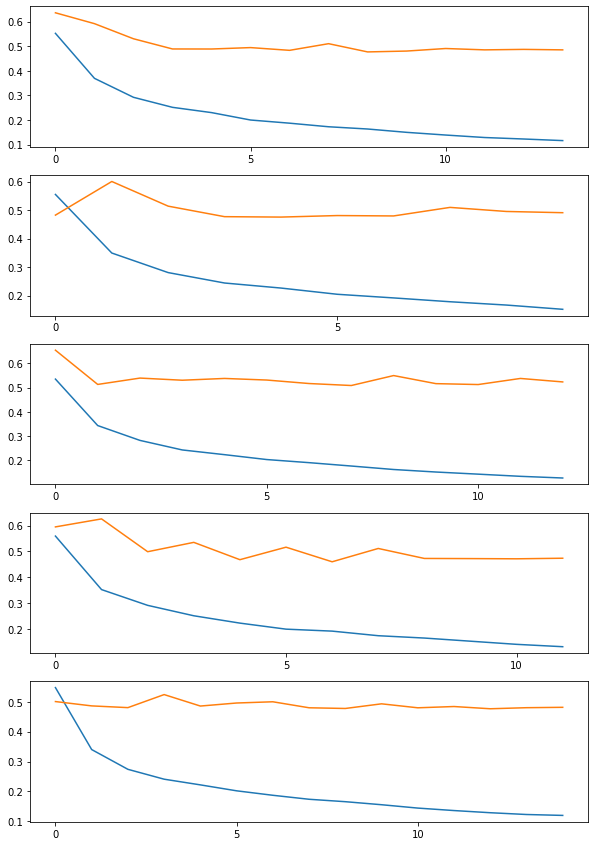

In [18]:
fig = plt.figure(figsize=(10, 15))
for fold in df_stats.fold.unique():
    ax = fig.add_subplot(5,1,fold)
    max_epoch = df_stats[df_stats['fold']==fold]['epoch'].max()
    x = np.arange(max_epoch)
    ax.plot(x,df_stats[df_stats['fold']==fold][['Training Loss']])
    ax.plot(x,df_stats[df_stats['fold']==fold][['Eval Loss']])
    plt.xticks(range(0, max_epoch, 5))